# Heat Exchanger

Story/Vorturnen

- Herleitung der Problematik
    - Adiabaten Wärmetauscher, der Wärme vollständig von Fluid a auf Fluid b transportiert
    - Wo ist da ein Energieverlust?
    - Temperaturen/Temperaturniveaus, es ist nicht umkehrbar!
    - Unser Beispiel: Das mit den beiden Heizungen (zeigen, wie die beiden sich unterscheiden! keine Analyse von unterschiedlichen Parametern)
- Übung: Wirkungsgrad/Verluste bei konstantem Wärmestrom und
    - unterschiedlichen Massenströme
    - unterschiedlichen Eintrittstemperaturen
    - unterschiedlichen Austrittstemperaturen
- Wärmeübertragung zweiter Fall (Verweis auf Möglichkeit weiterer Fälle)
    - Übertragung bei T <= T0 (-> Luftwärmepumpe Verdampfer)
    - Zeigen der Gleichungen
- Übung:
    - Einfacher Fall mit virtueller heißer Seite (also nur die Verdampfung bilanzieren)
    - Richtung Wärmestrom und Exergiestrom
    - Einfluss Verdampfungstemperatur
    - Erweiterung des Falls auf mit beiden Seite, heißer Eintritt bei Umgebungstemperatur!
    - Was ist jetzt eigentlich Aufwand und Nutzen?



## Introduction

A heat exchanger is used to transfer heat from one fluid to a different one. We can write the energy balance for the component assuming, that no heat is lost to the ambient.

```{math}
    :label: heat-exchanger-energy-balance
    0 = \dot m_1 \cdot \left(h_\text{1,out} - h_\text{1,in}\right) + \dot m_2 \cdot \left(h_\text{2,out} - h_\text{2,in}\right)
```

The hot side {math}`1` transfers heat to the cold side {math}`2`. We can see, that all heat provided by the hot side is transferred to the cold side. However, in this process it is not possible to reach the same temperature level on the cold side as on the hot side. Reversing the heat transfer is for the same reason not possible: You cannot transfer heat against the direction of the temperature gradient. That obviously means, that the heat transfer incurs thermodynamic losses. To make them visible, we will again calculate the exergy of each of the flows.


(ref:sec:heat-ex-dhs-radiator)=
## District heating delivery heat exchanger for radiator heating system

As an example we want to have a look at a home heating system that uses centralized distric heat as a source. To separate the district heating system from the home system, a heat exchangers is set in place. The radiator of the home system needs a feed flow temperature of {math}`70` degrees Celsius. By transfering heat to the home, its temperature reduces by {math}`15` Kelvin. It operates at a pressure of roughly {math}`1.5` bar above atmospheric pressure. The district heating system provides a flow of {math}`1 \frac{kg}{s}` with a temperature of {math}`90` degrees Celsius at {math}`8` bar above atmospheric pressure. It returns back with a temperature of {math}`60` degrees Celsius.


In [86]:
from CoolProp.CoolProp import PropsSI as PSI

# Properties of hot side fluid
fluid_1 = 'water'
m_dot_1 = 1  # kg/s
p_1 = (1.013 + 8) * 1e5  # Pa
T_in_1 = 90 + 273.15  # K
T_out_1 = 60 + 273.15  # K

# Properties of cold side fluid
fluid_2 = 'water'
p_2 = (1.013 + 1.5) * 1e5  # Pa
T_in_2 = 55 + 273.15  # K
T_out_2 = 70 + 273.15  # K


Let's find out how much water is flowing through the home heating system. To employ equation {eq}`heat-exchanger-energy-balance`, we have to get the specific enthalpies of our fluids.

In [87]:
h_in_1 = PSI('H', 'P', p_1, 'T', T_in_1, fluid_1)
h_out_1 = PSI('H', 'P', p_1, 'T', T_out_1, fluid_1)

h_in_2 = PSI('H', 'P', p_2, 'T', T_in_2, fluid_2)
h_out_2 = PSI('H', 'P', p_2, 'T', T_out_2, fluid_2)

m_dot_2 = m_dot_1 * (h_out_1 - h_in_1) / -(h_out_2 - h_in_2)

m_dot_2

2.00294954481023

The home heating system mass flow is about {math}`2 \frac{kg}{s}`, which makes sense due to the temperature spread of the radiator being smaller, than that of the district heat. After this calculation, we have all the information we need to calculate the physical exergy of both flows. For that we can use the function we built within the {ref}`ref:sec:adiabatic-pipe-flow` example. But first, we have to define an ambient state:

In [88]:
# Ambient state
p0 = 1.013 * 1e5  # Pa
T0 = 20 + 273.15  # K


```{tip}
We have provided the function to calculate the exergy in the 'utilities' file in this directory, so we can import it from there instead of redefining it here.
```

In [89]:
from utilities import calc_physical_exergy


ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1)
ex_out_1 = calc_physical_exergy(p_1, h_out_1, p0, T0, fluid_1)
ex_in_2 = calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2)
ex_out_2 = calc_physical_exergy(p_2, h_out_2, p0, T0, fluid_2)

In this specific case, all fluid temperatures are above our ambiant temperature. This means, that the following equations describe the fuel and product exergies:

```{math}
    :label: e_f-all-T-above-T0
    \dot{E}_F = \dot{E}^{PH}_{in,1} - \dot{E}^{PH}_{out,1} + \dot{E}^{M}_{in,2} - \dot{E}^{M}_{out,2}
```

```{math}
    :label: e_p-all-T-above-T0
    \dot{E}_P = \dot{E}^{T}_{out,2} - \dot{E}^{T}_{in,2}
```

Let's calculate them.

In [90]:
Ex_dot_F = m_dot_1 * (sum(ex_in_1) - sum(ex_out_1)) + m_dot_2 * (ex_in_2[1] - ex_out_2[1])
Ex_dot_P = m_dot_2 * (ex_out_2[0] - ex_in_2[0])

Ex_dot_F, Ex_dot_P

(19805.69808476692, 15906.4158830616)

The fuel exergy comes out to about {math}`19.81 kJ` and the product exergy to about {math}`15.91 kJ`. With these values, we can finally calculate exergy destruction, exergy destruction ratio and exergy efficiency. That works analogously as described in {ref}`ref:sec:adiabatic-pipe-flow`.

In [91]:
Ex_dot_D = Ex_dot_F - Ex_dot_P
y_D = Ex_dot_D / Ex_dot_F
eta_Ex = Ex_dot_P / Ex_dot_F

Ex_dot_D, y_D, eta_Ex

(3899.2822017053186, 0.19687678692347424, 0.8031232130765258)

The total exergy destruction is about {math}`3.899 kJ`, resulting in an exergy destruction ratio of about {math}`19.7` % and an exergy efficiency of about {math}`80.3` %.

## District heating delivery heat exchanger for underfloor heating system

Now lets compare the radiator with an underfloor heating system. Typically, these work at a feed flow temperature of {math}`40` degrees Celsius with a temperature spread of {math}`10` K.

In [92]:
T_in_2_uf = 30 + 273.15  # K
T_out_2_uf = 40 + 273.15  # K

h_in_2_uf = PSI('H', 'P', p_2, 'T', T_in_2_uf, fluid_2)
h_out_2_uf = PSI('H', 'P', p_2, 'T', T_out_2_uf, fluid_2)

m_dot_2_uf = m_dot_1 * (h_out_1 - h_in_1) / -(h_out_2_uf - h_in_2_uf)

What do you expect the result of the exergy analysis of the underfloor heater to be in comparison to the radiator. How do the lower system temperatures affect the fuel and product exergy? Take a guess before continuing.

Let's calculate the physical, as well as the fuel and product exergies.

In [93]:
ex_in_2_uf = calc_physical_exergy(p_2, h_in_2_uf, p0, T0, fluid_2)
ex_out_2_uf = calc_physical_exergy(p_2, h_out_2_uf, p0, T0, fluid_2)

Ex_dot_F_uf = m_dot_1 * (sum(ex_in_1) - sum(ex_out_1)) + m_dot_2_uf * (ex_in_2_uf[1] - ex_out_2_uf[1])
Ex_dot_P_uf = m_dot_2_uf * (ex_out_2_uf[0] - ex_in_2_uf[0])


With these, we can calculate exergy destruction, exergy destruction ratio and exergy efficiency again.

In [94]:
Ex_dot_D_uf = Ex_dot_F_uf - Ex_dot_P_uf
y_D_uf = Ex_dot_D_uf / Ex_dot_F_uf
eta_Ex_uf = Ex_dot_P_uf / Ex_dot_F_uf

Ex_dot_D_uf, y_D_uf, eta_Ex_uf

(13694.426035144455, 0.6914386948914059, 0.3085613051085941)

The total exergy destruction is about {math}`13.69 \frac{kJ}{kg}`, resulting in an exergy destruction ratio of about {math}`69.1` % and an exergy efficiency of about {math}`30.9` %. That's an **increase** in exergy destruction of around {math}`151.2` %.

Do the results match your expectations? What does this say about the process of providing heat to the underfloor system from the district heating system? How could a dhs operator reduce exergy destruction in home systems in general?

## Exercise 1

<span style="color:red">T ambient bei gleichem Prozess variieren</span>

The analysis above assumes a constant ambient state. In reality, the reference temperature for a heating system -- the temperature outside -- varies throughout the year. To find out how a varying ambient temperature influences the results of the exergy analysis above, do the following exercise for a typical temperature range of {math}`5` to {math}`30` degrees Celsius.

1. Using the radiator home system example as a use case, create a plot of the exergy destruction against the ambient temperature. How do you interprete the results?

### Proposed solution 1

In [ ]:
import matplotlib.pyplot as plt

T0_range = [T + 273.15 for T in range(5, 35, 5)]

Ex_dot_D_range = list()
for T0_val in T0_range:
    ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0_val, fluid_1)
    ex_out_1 = calc_physical_exergy(p_1, h_out_1, p0, T0_val, fluid_1)
    ex_in_2 = calc_physical_exergy(p_2, h_in_2, p0, T0_val, fluid_2)
    ex_out_2 = calc_physical_exergy(p_2, h_out_2, p0, T0_val, fluid_2)

    Ex_dot_F = m_dot_1 * (sum(ex_in_1) - sum(ex_out_1)) + m_dot_2 * (ex_in_2[1] - ex_out_2[1])
    Ex_dot_P = m_dot_2 * (ex_out_2[0] - ex_in_2[0])

    Ex_dot_D_range += [(Ex_dot_F - Ex_dot_P) * 1e-3]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    [T - 273.15 for T in T0_range],
    Ex_dot_D_range, color='#B54036'
    )

ax.set_ylabel('Exergy destruction in kJ')
ax.set_xlabel('Ambient temperature in °C')
ax.grid()
ax.set_axisbelow(True)

```{admonition} Explanation
:class: dropdown

What we can gather from the resulting plot is, that the exergy destruction increases with an increase in ambient temperature. This can be counter-intuitive, as the fuel and product exergy decrease in absolute terms. This seems reasonable, as the ambient temperature approaches all other temperature levels and therefore their respective potential to extract work decreases.

If we inspect fuel and product exergy, we can see, that the former decrease slower than the latter, which results in the observed increase in exergy destruction. The fuel exergy decreases slower, because it is mostly dependent on the thermal exergy of the hot side of the example heat exchanger.

As the temperatures of the hot side are higher than those on the cold side and with the thermal exergy increasing disproportionately with temperature increase above the ambient temperature, even with the same temperature drop the thermal exergy difference between inlet and outlet is always bigger. This effect amplifies with a bigger distance to the ambient temperature.
```

## Exercises 2

To further analyze the influence of the key parameters of a heat exchanger, let's variate them and study their effects. Based on the first example (see: {ref}`ref:sec:heat-ex-dhs-radiator`) and with a constant heat flow rate from hot to cold side, implement the following variation routines and plot the resulting exergy destruction and efficiency:

1. Variable inlet temperatures with constant outlet temperatures.
2. Variable outlet temperatures with constant inlet temperatures.

### Proposed solution 2.1

**Zeroth step:** Let's create some helper functions

In [95]:
def calc_massflow(which, m_dot, h_in_1, h_out_1, h_in_2, h_out_2):
    """Energy balance of heat exchanger that is adiabatic to surroundings."""
    if which == 'cold':
        return m_dot * (h_out_1 - h_in_1) / -(h_out_2 - h_in_2)
    elif which == 'hot':
        return m_dot * -(h_out_2 - h_in_2) / (h_out_1 - h_in_1)

def calc_ex_fuel_prod(m_dot_1, ex_in_1, ex_out_1, m_dot_2, ex_in_2, ex_out_2):
    """Defined for all temperatures above T0."""
    Ex_dot_F = (
        m_dot_1 * (sum(ex_in_1) - sum(ex_out_1))
        + m_dot_2 * (ex_in_2[1] - ex_out_2[1])
        )
    Ex_dot_P = m_dot_2 * (ex_out_2[0] - ex_in_2[0])
    return Ex_dot_F, Ex_dot_P

def plot_ex_D_eta_ex(T_range, Ex_D_range, eta_Ex_range):
    """Plot exergy destruction and efficiency against variable temperature."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(T_range, Ex_D_range, color='#B54036')
    axs[1].plot(T_range, eta_Ex_range, color='#00395B')

    axs[0].set_ylabel('Exergy destruction in kJ')
    axs[0].grid()
    axs[0].set_axisbelow(True)

    axs[1].set_ylabel('Exergetic efficiency')
    axs[1].grid()
    axs[1].set_axisbelow(True)

    return fig, axs


**First step:** Variate hot side inlet temperature

Text(0.5, 0.01, 'Feed flow temperature of district heating system in °C')

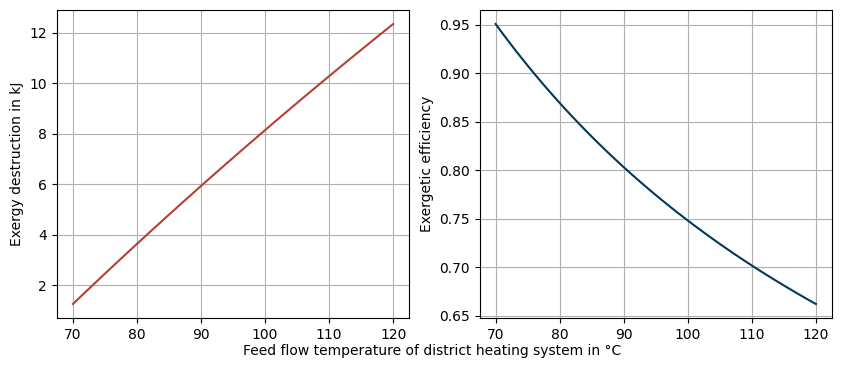

In [96]:
Q_nominal = abs(m_dot_1 * (h_out_1 - h_in_1))
m_dot_2 = Q_nominal / (h_out_2 - h_out_1)

T_in_1_range = [*range(70, 121)]
h_in_1_range = [PSI('H', 'P', p_1, 'T', T_in_1+273.15, fluid_1) for T_in_1 in T_in_1_range]
ex_in_1_range = [calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1) for h_in_1 in h_in_1_range]

m_dot_1_range = [
    calc_massflow('hot', m_dot_2, h_in_1, h_out_1, h_in_2, h_out_2) for h_in_1 in h_in_1_range
    ]

Ex_dot_D_range = list()
eta_Ex_range = list()
for ex_in_1, m_dot_1 in zip(ex_in_1_range, m_dot_1_range):
    Ex_dot_F, Ex_dot_P = calc_ex_fuel_prod(
        m_dot_1, ex_in_1, ex_out_1, m_dot_2, ex_in_2, ex_out_2
        )
    Ex_dot_D_range += [(Ex_dot_F - Ex_dot_P) * 1e-3]
    eta_Ex_range += [Ex_dot_P / Ex_dot_F]

fig, axs = plot_ex_D_eta_ex(T_in_1_range, Ex_dot_D_range, eta_Ex_range)

fig.supxlabel(
    'Feed flow temperature of district heating system in °C',
    fontsize='medium'
    )

Warum Wirkungsgrad bei 70 FF DHS nicht == 1?

**Second step:** Variate cold side inlet temperature

Text(0.5, 0.01, 'Back flow temperature of home heating system in °C')

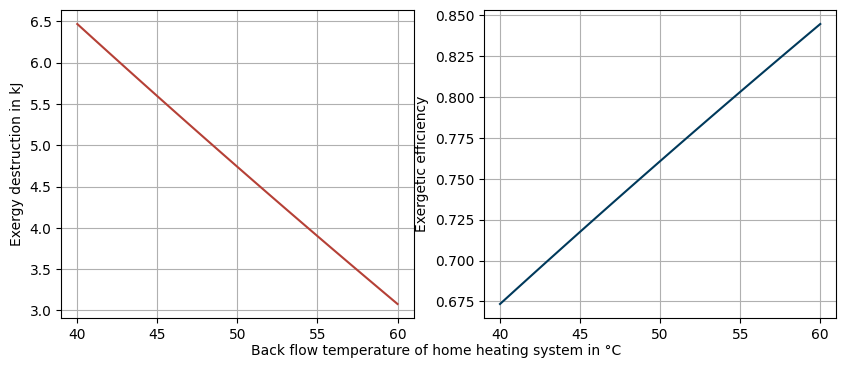

In [97]:
# Reset hot side inlet temperature
m_dot_1 = 1
T_in_1 = 90
h_in_1 = PSI('H', 'P', p_1, 'T', T_in_1+273.15, fluid_1)
ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1)

T_in_2_range = [*range(40, 61)]
h_in_2_range = [PSI('H', 'P', p_2, 'T', T_in_2+273.15, fluid_2) for T_in_2 in T_in_2_range]
ex_in_2_range = [calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2) for h_in_2 in h_in_2_range]
m_dot_2_range = [
    calc_massflow('cold', m_dot_1, h_in_1, h_out_1, h_in_2, h_out_2) for h_in_2 in h_in_2_range
    ]

Ex_dot_D_range = list()
eta_Ex_range = list()
for ex_in_2, m_dot_2 in zip(ex_in_2_range, m_dot_2_range):
    Ex_dot_F, Ex_dot_P = calc_ex_fuel_prod(m_dot_1, ex_in_1, ex_out_1, m_dot_2, ex_in_2, ex_out_2)
    Ex_dot_D_range += [(Ex_dot_F - Ex_dot_P) * 1e-3]
    eta_Ex_range += [Ex_dot_P / Ex_dot_F]

fig, axs = plot_ex_D_eta_ex(T_in_2_range, Ex_dot_D_range, eta_Ex_range)

fig.supxlabel(
    'Back flow temperature of home heating system in °C',
    fontsize='medium'
    )


**Third step:** Variate both inlet temperatures simultaneously

Text(0.5, 0.01, 'Back flow temperature of home heating system in °C')

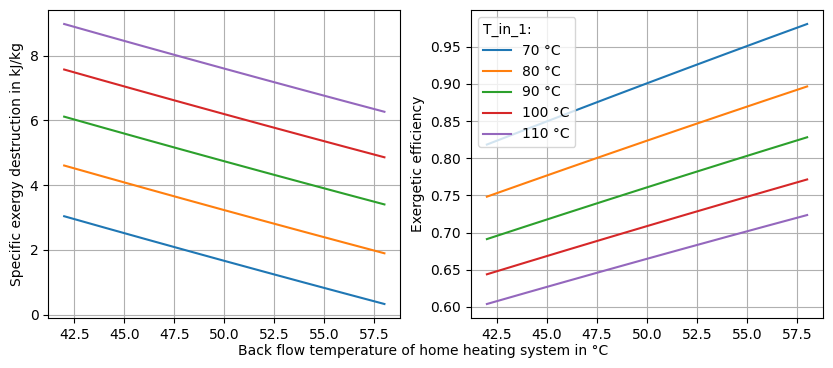

In [98]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for T_in_1 in range(70, 120, 10):
    h_in_1 = PSI('H', 'P', p_1, 'T', T_in_1+273.15, fluid_1)
    ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1)
    m_dot_1 = abs(Q_nominal / (h_out_1 - h_in_1))

    Ex_dot_D_range = list()
    eta_Ex_range = list()
    T_in_2_range = list()
    for T_in_2 in range(42, 60, 2):
        T_in_2_range += [T_in_2]
        h_in_2 = PSI('H', 'P', p_2, 'T', T_in_2+273.15, fluid_2)
        ex_in_2 = calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2)
        m_dot_2 = calc_massflow('cold', m_dot_1, h_in_1, h_out_1, h_in_2, h_out_2)

        Ex_dot_F, Ex_dot_P = calc_ex_fuel_prod(
            m_dot_1, ex_in_1, ex_out_1, m_dot_2, ex_in_2, ex_out_2
            )
        Ex_dot_D_range += [(Ex_dot_F - Ex_dot_P) * 1e-3]
        eta_Ex_range += [Ex_dot_P / Ex_dot_F]

    axs[0].plot(T_in_2_range, Ex_dot_D_range, label=f'{T_in_1:.0f} °C')
    axs[1].plot(T_in_2_range, eta_Ex_range, label=f'{T_in_1:.0f} °C')

axs[0].set_ylabel('Specific exergy destruction in kJ/kg')
axs[0].grid()
axs[0].set_axisbelow(True)

axs[1].set_ylabel('Exergetic efficiency')
axs[1].grid()
axs[1].set_axisbelow(True)
axs[1].legend(title='T_in_1:', alignment='left')

fig.supxlabel(
    'Back flow temperature of home heating system in °C',
    fontsize='medium'
    )

### Proposed solution 2.2

**First step:** Variate hot side outlet temperature

Text(0.5, 0.01, 'Back flow temperature of district heating system in °C')

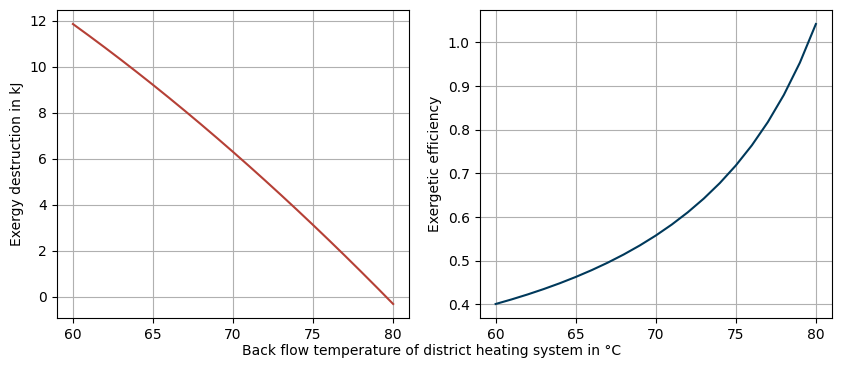

In [51]:
# Reset inlet temperatures
T_in_1 = 90
h_in_1 = PSI('H', 'P', p_1, 'T', T_in_1+273.15, fluid_1)
ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1)
T_in_2 = 55
h_in_2 = PSI('H', 'P', p_2, 'T', T_in_2+273.15, fluid_2)
ex_in_2 = calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2)

T_out_1_range = [*range(60, 81)]
h_out_1_range = [PSI('H', 'P', p_1, 'T', T_out_1+273.15, fluid_1) for T_out_1 in T_out_1_range]
ex_out_1_range = [calc_physical_exergy(p_1, h_out_1, p0, T0, fluid_1) for h_out_1 in h_out_1_range]

ex_D_range = list()
eta_ex_range = list()
for ex_out_1 in ex_out_1_range:
    ex_F = sum(ex_in_1) - sum(ex_out_1) + ex_in_2[1] - ex_out_2[1]
    ex_P = ex_out_2[0] - ex_in_2[0]
    ex_D_range += [(ex_F - ex_P) * 1e-3]
    eta_ex_range += [ex_P / ex_F]

fig, axs = plot_ex_D_eta_ex(T_out_1_range, ex_D_range, eta_ex_range)

fig.supxlabel(
    'Back flow temperature of district heating system in °C',
    fontsize='medium'
    )

**Second step:** Variate cold side outlet temperature

Text(0.5, 0.01, 'Feed flow temperature of home heating system in °C')

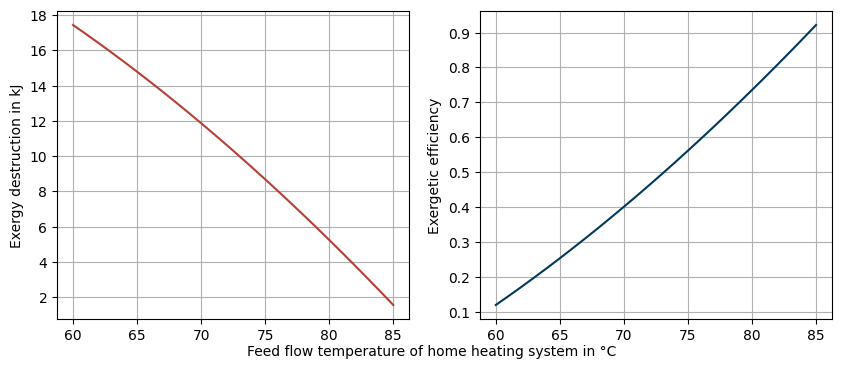

In [52]:
# Reset hot side outlet temperature
T_out_1 = 60
h_out_1 = PSI('H', 'P', p_1, 'T', T_out_1+273.15, fluid_1)
ex_out_1 = calc_physical_exergy(p_1, h_out_1, p0, T0, fluid_1)

T_out_2_range = [*range(60, 86)]
h_out_2_range = [PSI('H', 'P', p_2, 'T', T_out_2+273.15, fluid_2) for T_out_2 in T_out_2_range]
ex_out_2_range = [calc_physical_exergy(p_2, h_out_2, p0, T0, fluid_2) for h_out_2 in h_out_2_range]

ex_D_range = list()
eta_ex_range = list()
for ex_out_2 in ex_out_2_range:
    ex_F = sum(ex_in_1) - sum(ex_out_1) + ex_in_2[1] - ex_out_2[1]
    ex_P = ex_out_2[0] - ex_in_2[0]
    ex_D_range += [(ex_F - ex_P) * 1e-3]
    eta_ex_range += [ex_P / ex_F]

fig, axs = plot_ex_D_eta_ex(T_out_2_range, ex_D_range, eta_ex_range)
fig.supxlabel(
    'Feed flow temperature of home heating system in °C',
    fontsize='medium'
    )

**Third step:** Variate both outlet temperatures simultaneously

Text(0.5, 0.01, 'Feed flow temperature of home heating system in °C')

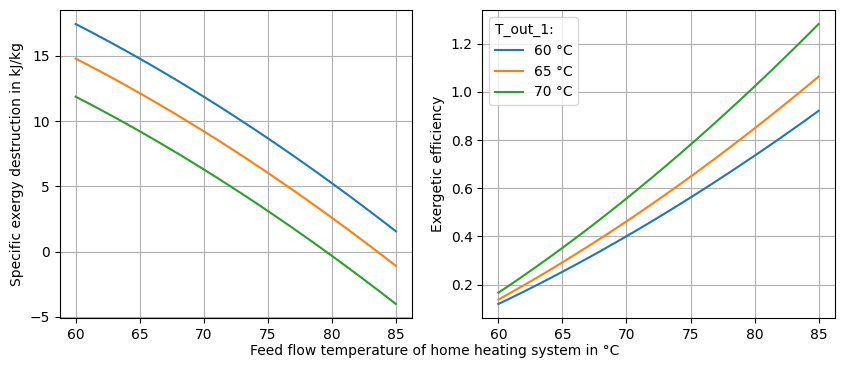

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for T_out_1 in range(60, 75, 5):
    h_out_1 = PSI('H', 'P', p_1, 'T', T_out_1+273.15, fluid_1)
    ex_out_1 = calc_physical_exergy(p_1, h_out_1, p0, T0, fluid_1)

    ex_D_range = list()
    eta_ex_range = list()
    T_out_2_range = list()
    for T_out_2 in range(60, 86):
        T_out_2_range += [T_out_2]
        h_out_2 = PSI('H', 'P', p_2, 'T', T_out_2+273.15, fluid_2)
        ex_out_2 = calc_physical_exergy(p_2, h_out_2, p0, T0, fluid_2)

        ex_F = sum(ex_in_1) - sum(ex_out_1) + ex_in_2[1] - ex_out_2[1]
        ex_P = ex_out_2[0] - ex_in_2[0]
        ex_D_range += [(ex_F - ex_P) * 1e-3]
        eta_ex_range += [ex_P / ex_F]

    axs[0].plot(T_out_2_range, ex_D_range, label=f'{T_out_1:.0f} °C')
    axs[1].plot(T_out_2_range, eta_ex_range, label=f'{T_out_1:.0f} °C')

axs[0].set_ylabel('Specific exergy destruction in kJ/kg')
axs[0].grid()
axs[0].set_axisbelow(True)

axs[1].set_ylabel('Exergetic efficiency')
axs[1].grid()
axs[1].set_axisbelow(True)
axs[1].legend(title='T_out_1:', alignment='left')

fig.supxlabel(
    'Feed flow temperature of home heating system in °C',
    fontsize='medium'
    )

## Evaporator of an air-water heat pump

For our next example, consider the heat exchanger used for evaporation of the refrigerant of an air-water heat pump. As the name implies, ambient air used as the heat source of the cycle. That means, that the ambient temperature {math}`T_0` occurs at the inlet of the hot side of the evaporator. As the air is supplying the heat, its temperatures decreases until it exits the heat exchanger. The evaporation of the refrigerant must occur at an even lower temperature. This means, that all temperatures lie at our below the defined ambient temperature {math}`T_0`, so that the definition of fuel and product exergy change.

## Lessons Learned

- What did you learn?
- What should you be able to apply yourself?